In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import zipfile
import os

# Path to your zip file
zip_file_path = '/content/drive/MyDrive/classification_img_2024/chevreuil_blaireau_google.zip'

# Path to the directory where you want to unzip the file
output_dir = '/content/chevreuil_blaireau_google'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f'File unzipped to {output_dir}')

File unzipped to /content/chevreuil_blaireau_google


In [ ]:
import random
import shutil

# Paths to the class folders
chevreuil_dir = '/content/chevreuil_blaireau_google/chevreuil_blaireau_google/chevreuil'
blaireau_dir = '/content/chevreuil_blaireau_google/chevreuil_blaireau_google/blaireau'

# Creating the train and validation folders
train_dir = '/content/chevreuil_blaireau_google/train'
val_dir = '/content/chevreuil_blaireau_google/validation'

os.makedirs(os.path.join(train_dir, 'chevreuil'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'blaireau'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'chevreuil'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'blaireau'), exist_ok=True)

def split_data(source_dir, train_dir, val_dir, split_ratio=0.8):
    # List files in the source directory
    files = os.listdir(source_dir)
    random.shuffle(files)  # Shuffle files

    # Calculate the number of files for training and validation
    split_index = int(len(files) * split_ratio)
    train_files = files[:split_index]
    val_files = files[split_index:]

    # Move files to the respective directories
    for file_name in train_files:
        shutil.move(os.path.join(source_dir, file_name), os.path.join(train_dir, file_name))

    for file_name in val_files:
        shutil.move(os.path.join(source_dir, file_name), os.path.join(val_dir, file_name))

# Splitting chevreuil images
split_data(chevreuil_dir, os.path.join(train_dir, 'chevreuil'), os.path.join(val_dir, 'chevreuil'))

# Splitting blaireau images
split_data(blaireau_dir, os.path.join(train_dir, 'blaireau'), os.path.join(val_dir, 'blaireau'))

print("Image split complete.")

Image split complete.


In [ ]:
!rm -rf /content/chevreuil_blaireau_google/chevreuil_blaireau_google/blaireau
!rm -rf /content/chevreuil_blaireau_google/chevreuil_blaireau_google/chevreuil
!rm -rf /content/chevreuil_blaireau_google/__MACOSX
!rm -rf /content/chevreuil_blaireau_google/chevreuil_blaireau_google

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2

In [ ]:
# Define the paths to your image folders
base_path = '/content/chevreuil_blaireau_google/'
train_path = base_path + 'train/'
validation_path = base_path + 'validation/'

In [ ]:
# Parameters
image_size = (224, 224)
batch_size = 32
epochs = 10

In [ ]:
# Data preparation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 489 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


In [ ]:
# Load the pre-trained MobileNetV2 model on ImageNet, without the last classification layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the layers in the base model
base_model.trainable = False

# Add new classification layers for our chevreuil vs blaireau problem
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Flatten the output of the last convolutional layer
    layers.Dense(64, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10  # Increase if needed
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 987ms/step - accuracy: 0.6986 - loss: 0.5263 - val_accuracy: 0.9440 - val_loss: 0.1080
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - accuracy: 0.9438 - loss: 0.1419 - val_accuracy: 0.9600 - val_loss: 0.0820
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 305ms/step - accuracy: 0.9639 - loss: 0.0812 - val_accuracy: 0.9600 - val_loss: 0.0786
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 385ms/step - accuracy: 0.9649 - loss: 0.0599 - val_accuracy: 0.9680 - val_loss: 0.0710
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.9887 - loss: 0.0356 - val_accuracy: 0.9600 - val_loss: 0.0849
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.9804 - loss: 0.0527 - val_accuracy: 0.9280 - val_loss: 0.1102
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.9902 - loss: 0.0349 - val_accuracy: 0.9680 - val_loss: 0.0749
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - accuracy: 0.9870 - loss: 0.0437 - val_accuracy: 0.9680 - v

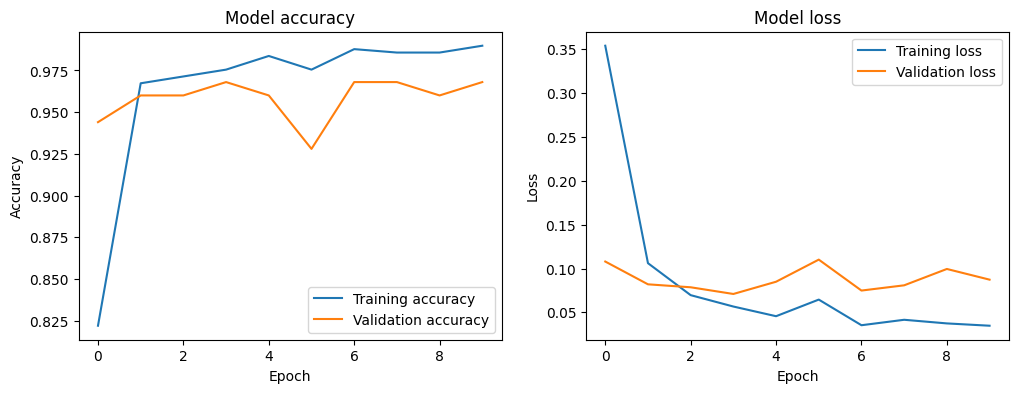

In [ ]:
# Display learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Found 125 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 902ms/step


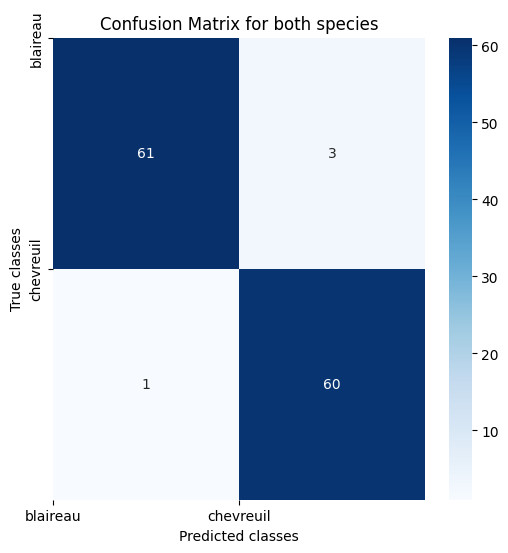

Overall accuracy: 96.80%


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Parameters
validation_path = '/content/chevreuil_blaireau_google/validation/'
image_size = (224, 224)
batch_size = 32

# 1. Create a validation generator WITHOUT shuffling (shuffle=False)
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Do not shuffle data to maintain order
)

# 2. Make predictions
Y_pred = model.predict(validation_generator)
y_pred_classes = (Y_pred > 0.5).astype(int)  # Convert probabilities to classes (0 or 1)

# 3. Retrieve true classes in the same order
y_true = validation_generator.classes  # True classes (0 for blaireau, 1 for chevreuil)

# 4. Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 5. Visualize confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.title('Confusion Matrix for both species')
plt.xticks([0, 1], ['blaireau', 'chevreuil'])
plt.yticks([0, 1], ['blaireau', 'chevreuil'])
plt.show()

# 6. Display summary of results
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Overall accuracy: {accuracy:.2%}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


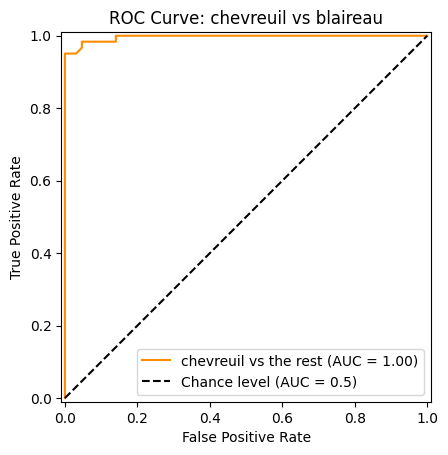

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize

# Predict on validation set
Y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

# Plot ROC curve
class_of_interest = "chevreuil"  # or "blaireau"
class_id = list(validation_generator.class_indices.keys()).index(class_of_interest)

# Binarize true labels if needed (in your case, they're already binary: 0 or 1)
# If classes aren't in 0/1 form, binarize manually
y_true_bin = label_binarize(y_true, classes=[0, 1])

# Plot ROC curve
display = RocCurveDisplay.from_predictions(
    y_true_bin[:, 0],  # True labels for the class of interest
    Y_pred,  # Predicted probabilities for the class of interest
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True
)

_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"ROC Curve: {class_of_interest} vs blaireau"
)

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


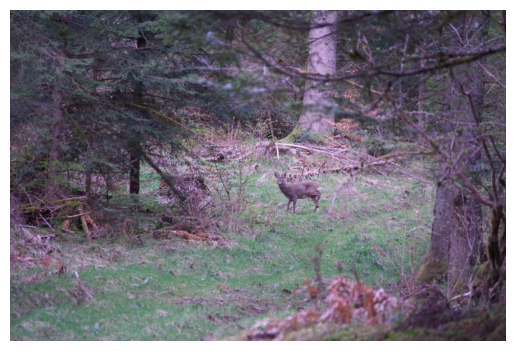

Prédiction: Roe deer (confidence : 99.23%)


In [22]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Function to load and prep an image
def load_and_prep_image(img_path, img_size=(224, 224)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # rescale
    return img_array

# Function to load and prep an image
def classify_image(img_path):
    # load and prepare image
    img_array = load_and_prep_image(img_path)

    # Predict
    prediction = model.predict(img_array)[0][0]

    # Display the image
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Print prediction
    if prediction >= 0.5:
        print(f"Prédiction: Roe deer (confidence : {prediction*100:.2f}%)")
    else:
        print(f"Prédiction: Badger (confidence : {(1-prediction)*100:.2f}%)")

# Path to the image you want to classify
img_path = '/content/drive/MyDrive/blaireau.jpeg'

# Classify the image
classify_image(img_path)